# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [47]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.331602
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The random weights that we used were close to zero so the activation was also near zero. The loss L_i will in that case be: L_i ~= -log[ e^0/Sum(e^0) ] = -log[1/C] = -log(1/10) = -log(0.1), where C is the number of classes which in this dataset is 10. 


In [35]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.671935 analytic: -2.671936, relative error: 1.217075e-08
numerical: 0.057172 analytic: 0.057172, relative error: 1.140140e-07
numerical: -1.232406 analytic: -1.232406, relative error: 1.020132e-08
numerical: -0.726819 analytic: -0.726819, relative error: 4.338611e-08
numerical: 1.881530 analytic: 1.881530, relative error: 4.204362e-08
numerical: -0.002780 analytic: -0.002780, relative error: 7.171709e-06
numerical: 1.606109 analytic: 1.606109, relative error: 1.942093e-08
numerical: -1.560987 analytic: -1.560987, relative error: 5.781093e-10
numerical: 1.748220 analytic: 1.748220, relative error: 3.883825e-08
numerical: -0.871999 analytic: -0.871999, relative error: 4.913828e-08
numerical: 4.330843 analytic: 4.330843, relative error: 1.235073e-08
numerical: 2.585033 analytic: 2.585033, relative error: 1.630098e-09
numerical: -2.949584 analytic: -2.949584, relative error: 1.182510e-09
numerical: -1.425099 analytic: -1.425099, relative error: 6.160852e-08
numerical: 0.47235

In [48]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.331602e+00 computed in 0.113960s
vectorized loss: 2.331602e+00 computed in 0.020788s
Loss difference: 0.000000
Gradient difference: 0.000000


iteration 0 / 1500: loss 388.244599
iteration 100 / 1500: loss 234.369921
iteration 200 / 1500: loss 142.332294
iteration 300 / 1500: loss 86.888747
iteration 400 / 1500: loss 53.324177
iteration 500 / 1500: loss 32.980640
iteration 600 / 1500: loss 20.793528
iteration 700 / 1500: loss 13.378824
iteration 800 / 1500: loss 8.932837
iteration 900 / 1500: loss 6.180770
iteration 1000 / 1500: loss 4.582999
iteration 1100 / 1500: loss 3.534965
iteration 1200 / 1500: loss 2.956574
iteration 1300 / 1500: loss 2.541527
iteration 1400 / 1500: loss 2.347544
That took 23.787445s


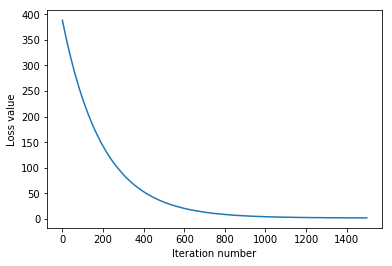

training accuracy: 0.351673
validation accuracy: 0.368000


In [52]:
#temp to check because i skipped Softmax
from cs231n.classifiers import Softmax
soft = Softmax()
tic = time.time()
loss_hist = soft.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

y_train_pred = soft.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = soft.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [61]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for r in regularization_strengths:
        soft = Softmax()
        #train
        loss_hist = soft.train(X_train, y_train, learning_rate=lr, reg=r,
                      num_iters=1000, verbose=True)
        #predict 
        y_train_pred = soft.predict(X_train)
        y_val_pred = soft.predict(X_val)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr,r)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = soft
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 5.757684
iteration 100 / 1000: loss 4.336013
iteration 200 / 1000: loss 3.654845
iteration 300 / 1000: loss 3.469958
iteration 400 / 1000: loss 3.164240
iteration 500 / 1000: loss 3.190746
iteration 600 / 1000: loss 2.948417
iteration 700 / 1000: loss 3.154338
iteration 800 / 1000: loss 3.009194
iteration 900 / 1000: loss 2.819130
iteration 0 / 1000: loss 391.169665
iteration 100 / 1000: loss 235.745545
iteration 200 / 1000: loss 143.191251
iteration 300 / 1000: loss 87.488573
iteration 400 / 1000: loss 53.580939
iteration 500 / 1000: loss 33.226204
iteration 600 / 1000: loss 20.924672
iteration 700 / 1000: loss 13.477195
iteration 800 / 1000: loss 8.944887
iteration 900 / 1000: loss 6.148496
iteration 0 / 1000: loss 779.907199
iteration 100 / 1000: loss 286.443359
iteration 200 / 1000: loss 106.195791
iteration 300 / 1000: loss 40.211016
iteration 400 / 1000: loss 15.963337
iteration 500 / 1000: loss 7.160243
iteration 600 / 1000: loss 3.957170
iteration 700 /

In [63]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.343000


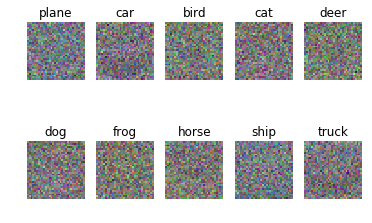

In [64]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])